
# Extracion de datos


In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Total images : 153
Total annotation : 153
Total annotation_digits : 142


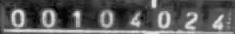

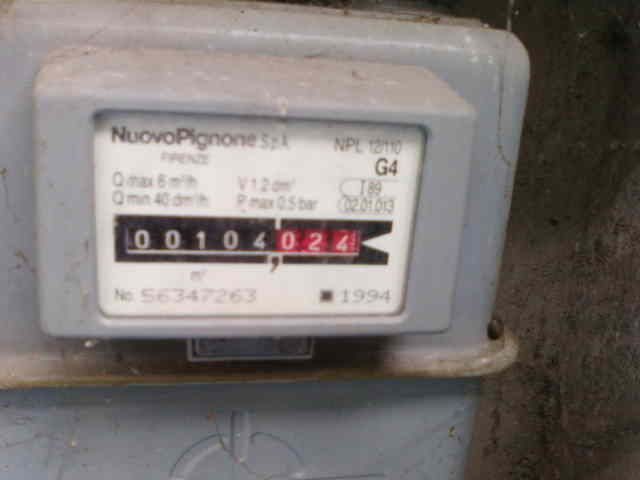

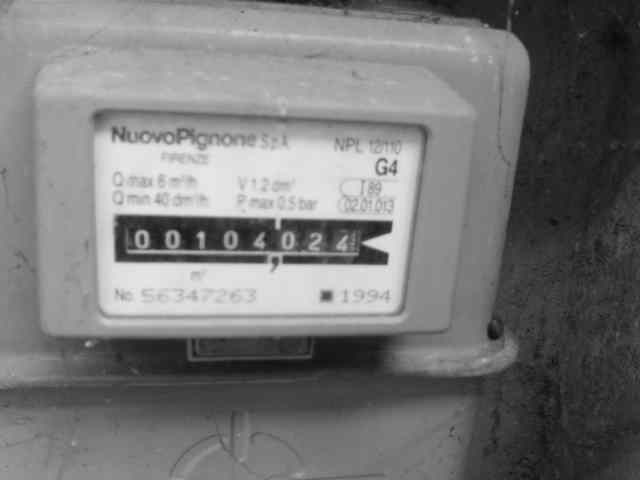

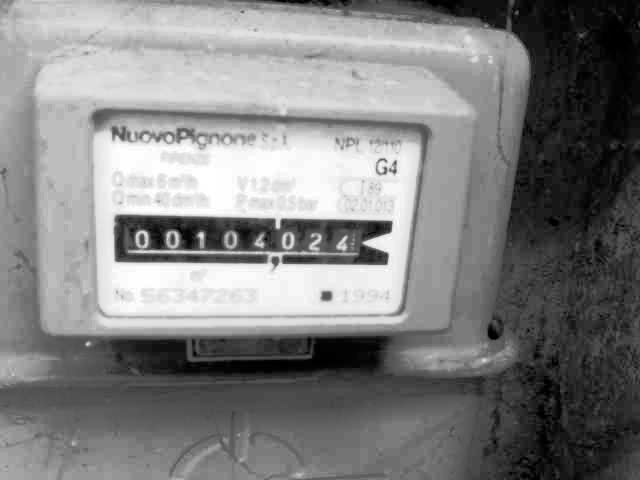

<Figure size 720x720 with 0 Axes>

In [ ]:
carpeta_imagenes = "/content/drive/MyDrive/TFG/Fotos/Gas-Meter-Counter/JPEGImages"
carpeta_anotaciones = "/content/drive/MyDrive/TFG/Fotos/Gas-Meter-Counter/Annotations"
carpeta_anotaciones_digits = "/content/drive/MyDrive/TFG/Fotos/Gas-Meter-Counter/Annotations_digits"
carpeta_salida = "/content/drive/MyDrive/TFG/Fotos/Salida recortes"
carpeta_salida_entrenar = "/content/drive/MyDrive/TFG/Fotos/Salida_para_entrenar"

#crop images
import numpy as np # linear algebra
import xml.etree.ElementTree as ET # for parsing XML
from PIL import Image # to read images
import os
import glob
import cv2 as cv
from matplotlib import pyplot as plt
import uuid

root_images=carpeta_imagenes
root_annots=carpeta_anotaciones
root_annots_digits=carpeta_anotaciones_digits

all_images=os.listdir(carpeta_imagenes)
print(f"Total images : {len(all_images)}")

breeds = glob.glob(carpeta_anotaciones)
annotation=[]
for b in breeds:
    annotation+=glob.glob(b+"/*")
print(f"Total annotation : {len(annotation)}")

breeds = glob.glob(carpeta_anotaciones_digits)
annotation_digits=[]
for b in breeds:
    annotation_digits+=glob.glob(b+"/*")
print(f"Total annotation_digits : {len(annotation_digits)}")

breed_map={}
for annot in annotation_digits:
    breed=annot.split("/")[-2]
    index=breed.split("-")[0]
    breed_map.setdefault(index,breed)



def get_digits(image):
    bpath=root_annots_digits+"/"+str(image.split(".")[0]+".xml")
    try:
      tree = ET.parse(bpath)
    except:
      return []
    root = tree.getroot()
    objects = root.findall('object')
    
    digits = []
    for o in objects:
        name = o.find('name').text # reading bound box
        digits.append(name)
        
    return digits

def bounding_box(image):
    bpath=root_annots+"/"+str(image.split(".")[0]+".xml")
    tree = ET.parse(bpath)
    root = tree.getroot()
    objects = root.findall('object')
    
    for o in objects:
        bndbox = o.find('bndbox') # reading bound box
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        
        
    return (xmin,ymin,xmax,ymax)
    
plt.figure(figsize=(10,10))
bbox=[]
for i,image in enumerate(all_images):
    image = all_images[1]
    bbox=bounding_box(image) 
    digits = get_digits(image)
    im = cv.imread(os.path.join(root_images,image),cv.IMREAD_GRAYSCALE)
    im = cv.equalizeHist(im)
    
    im = im[bbox[1]:bbox[3],bbox[0]:bbox[2]]
    cv2_imshow(im)
    for i in range(len(digits)):
      num = digits[i]
      
      ancho = int(im.shape[1]/len(digits))
      dig_im = im[0:im.shape[0],(i*ancho):(i*ancho)+ancho]
      dim = (28, 28)
      dig_im = cv.resize(dig_im, dim, interpolation = cv.INTER_AREA)
      cv2_imshow(dig_im)
      cv.imwrite(carpeta_salida_entrenar+'/{}_{}.jpg'.format(num,uuid.uuid4().hex),dig_im)

# Entrenar la red neuronal

In [17]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import MaxPool2D
from keras.layers import InputLayer
import cv2 as cv
import numpy as np
import random,os

carpeta_salida_entrenar = "/content/drive/MyDrive/TFG/Fotos/Salida_para_entrenar"
all_images=os.listdir(carpeta_salida_entrenar)
random.shuffle(all_images)

_y = []
for image in all_images:
  _y.append(image.split("_")[0])


unique, counts = np.unique(_y, return_counts=True)
print(dict(zip(unique, counts)))

mean = np.mean(counts)
mean = int(mean + mean*0.2)

for i,count in zip(unique,counts):
  if count > mean:
    for j in range(count - mean):
      for image in all_images:
        if i == image.split("_")[0]:
          all_images.remove(image)
          break

train_images = all_images[:int(len(all_images)*0.8)]
test_images = all_images[int(len(all_images)*0.8):]
x_train = np.ndarray(shape=(len(train_images),28,28))
y_train = np.ndarray(shape=(len(train_images),))
x_test = np.ndarray(shape=(len(test_images),28,28))
y_test = np.ndarray(shape=(len(test_images),))
for i in range(len(train_images)):
  image = train_images[i]
  x_train[i] = cv.imread(os.path.join(carpeta_salida_entrenar,image),cv.IMREAD_GRAYSCALE)
  y_train[i] = image.split("_")[0]

for i in range(len(test_images)):
  image = test_images[i]
  x_test[i] = cv.imread(os.path.join(carpeta_salida_entrenar,image),cv.IMREAD_GRAYSCALE)
  y_test[i] = image.split("_")[0]

unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))


{'0': 204, '1': 132, '2': 117, '3': 98, '4': 108, '5': 97, '6': 80, '7': 81, '8': 83, '9': 94}
{0.0: 96, 1.0: 107, 2.0: 91, 3.0: 77, 4.0: 90, 5.0: 80, 6.0: 73, 7.0: 66, 8.0: 66, 9.0: 70}


Model: "sequential_4"
________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           
 batch_normalization_4 (BatchNormalization)           (None, 28, 28, 1)                               4                 
                                                                                                                        
 conv2d_12 (Conv2D)                                   (None, 28, 28, 32)                              320               
                                                                                                                        
 max_pooling2d_12 (MaxPooling2D)                      (None, 14, 14, 32)                              0                 
                                                                                                                        
 conv2d_13

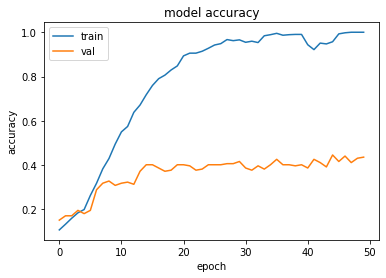

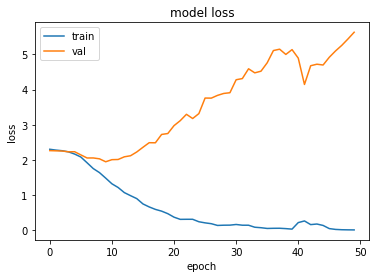

In [ ]:
model = Sequential()
model.add(BatchNormalization(input_shape=(28,28,1),dtype=tf.float32))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64,activation="relu"))
model.add(Dense(10, activation = "softmax"))


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary(line_length=120)

historico = model.fit(x_train, y_train, epochs=50,  validation_freq=1, validation_data=(x_test, y_test))


## plots de evolución de loss y accuracy
from matplotlib import pyplot as plt
plt.plot(historico.history['accuracy'])
plt.plot(historico.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(historico.history['loss'])
plt.plot(historico.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:

model.save('modelo.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

!ls -lah

INFO:tensorflow:Assets written to: /tmp/tmp8y8fxvnh/assets


INFO:tensorflow:Assets written to: /tmp/tmp8y8fxvnh/assets


total 684K
drwxr-xr-x 1 root root 4.0K Jun 13 19:12 .
drwxr-xr-x 1 root root 4.0K Jun 13 18:47 ..
drwxr-xr-x 4 root root 4.0K Jun  1 13:49 .config
drwx------ 6 root root 4.0K Jun 13 18:51 drive
-rw-r--r-- 1 root root 507K Jun 13 22:26 modelo.h5
-rw-r--r-- 1 root root 153K Jun 13 22:26 model.tflite
drwxr-xr-x 1 root root 4.0K Jun  1 13:50 sample_data


# Pruebas del modelo

[{'name': 'serving_default_batch_normalization_input:0', 'index': 0, 'shape': array([ 1, 28, 28,  1], dtype=int32), 'shape_signature': array([-1, 28, 28,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
(28, 28)
(1, 28, 28, 1)
[[3.9966293e-05 8.9205742e-01 1.2711546e-12 1.0788549e-01 2.7389113e-09
  4.8477350e-06 7.0477320e-08 3.2767331e-14 1.2197739e-05 5.6340460e-10]]


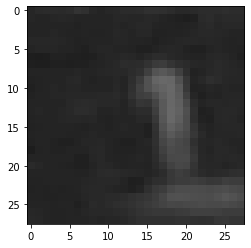

Resultado:  1
(28, 28)
(1, 28, 28, 1)
[[9.9835347e-07 4.6665591e-07 2.6739309e-09 8.6210566e-05 2.2915258e-06
  9.9960452e-01 2.5764812e-04 1.3320533e-15 2.7683380e-05 2.0278896e-05]]


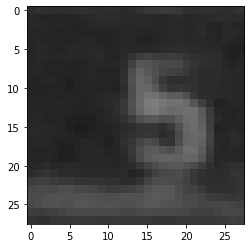

Resultado:  5
(28, 28)
(1, 28, 28, 1)
[[7.5760708e-12 9.9998021e-01 1.5087311e-16 1.9812138e-05 7.7583136e-14
  2.1201760e-10 1.6533934e-11 4.5763850e-19 4.9885909e-09 8.9287547e-15]]


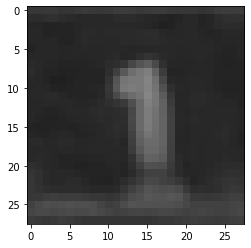

Resultado:  1
(28, 28)
(1, 28, 28, 1)
[[4.7852482e-11 1.5245986e-06 1.5884400e-08 9.9999177e-01 8.3073270e-10
  6.5375325e-06 1.8829249e-09 4.5530763e-16 1.1660626e-07 2.6973211e-08]]


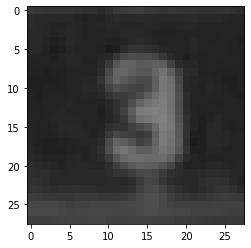

Resultado:  3
(28, 28)
(1, 28, 28, 1)
[[3.3946469e-04 3.4976541e-08 2.1425851e-11 6.2313191e-08 1.6183410e-08
  1.0451996e-04 9.5982373e-01 2.5316886e-12 3.9286267e-02 4.4589760e-04]]


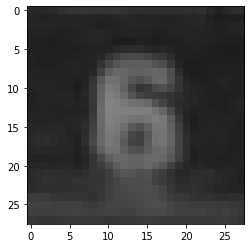

Resultado:  6
(28, 28)
(1, 28, 28, 1)
[[2.2352312e-03 8.0030759e-06 7.8506059e-07 2.0195961e-04 9.6323311e-07
  8.3599014e-05 1.6634418e-02 5.6908851e-09 9.4705349e-01 3.3781528e-02]]


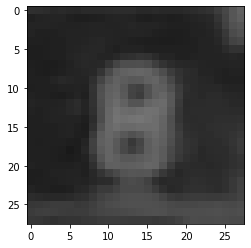

Resultado:  8
(28, 28)
(1, 28, 28, 1)
[[9.4855535e-01 1.8790039e-05 1.3981459e-08 9.0725401e-09 8.3450720e-07
  3.5799923e-07 4.9812939e-02 1.6112440e-07 1.2541958e-03 3.5733482e-04]]


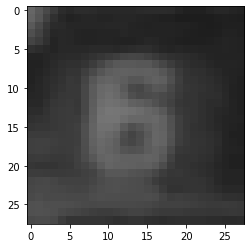

Resultado:  0
(28, 28)
(1, 28, 28, 1)
[[9.8991269e-01 3.6278022e-03 4.5264848e-08 3.0599367e-07 3.3638200e-06
  3.6570032e-06 5.3964951e-04 1.3349940e-06 5.6162202e-03 2.9500868e-04]]


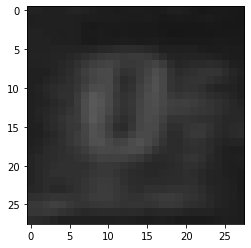

Resultado:  0


In [20]:
#Probar el codigo con imagenes de esp32
import tensorflow as tf
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
# Test the model on random input data.
input_shape = input_details[0]['shape']
for i in range(8):
    input_data = cv.imread(str(i)+".bmp",cv.IMREAD_GRAYSCALE)
    #input_data = cv.equalizeHist(input_data)
    print(input_data.shape)
    input_data = np.float32(input_data).reshape([1,28,28,1])
    print(input_data.shape)
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    print(output_data)
    input_data =input_data.reshape([28,28])
    plt.imshow(input_data,cmap='gray', vmin=0, vmax=255)
    plt.show()
    print("Resultado: ",np.argmax(output_data))
    #print(output_data.index(max(output_data)))

[{'name': 'serving_default_batch_normalization_input:0', 'index': 0, 'shape': array([ 1, 28, 28,  1], dtype=int32), 'shape_signature': array([-1, 28, 28,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
(28, 28)
(1, 28, 28, 1)
25
[[4.8224110e-04 8.7905600e-04 2.8603505e-02 5.9970599e-01 4.2124779e-05
  2.6069171e-04 1.6075296e-03 2.0284511e-04 3.4267094e-02 3.3394900e-01]]


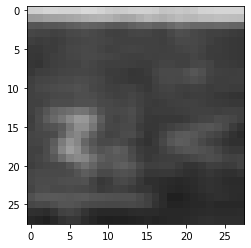

Resultado:  3  Esperado:  3
(28, 28)
(1, 28, 28, 1)
25
[[2.0868722e-05 2.3904795e-06 1.9739905e-06 7.8691996e-04 9.1389811e-04
  2.2700892e-03 9.5807910e-01 2.0770081e-05 3.7810367e-02 9.3656810e-05]]


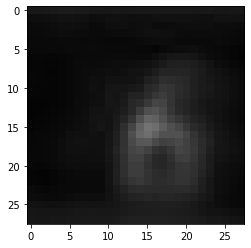

Resultado:  6  Esperado:  6
(28, 28)
(1, 28, 28, 1)
25
[[6.8094312e-05 2.7752673e-04 4.2338582e-04 5.1024663e-03 2.2787475e-05
  9.6107638e-01 1.0521699e-04 2.2140443e-02 2.1887690e-06 1.0781534e-02]]


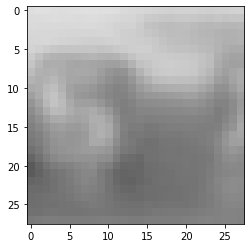

Resultado:  5  Esperado:  5
(28, 28)
(1, 28, 28, 1)
25
[[4.1677659e-10 8.1603286e-16 8.0479830e-17 2.5477016e-12 2.0518318e-18
  3.2941060e-11 2.7031021e-07 3.3124144e-30 2.2794298e-05 9.9997699e-01]]


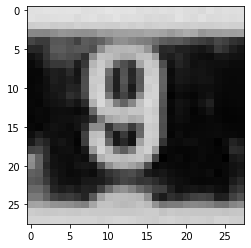

Resultado:  9  Esperado:  9
(28, 28)
(1, 28, 28, 1)
25
[[9.9997771e-01 2.2273844e-05 8.2175130e-13 3.4960657e-09 3.4758092e-15
  5.3749566e-10 2.4722675e-13 3.9266961e-15 2.4563468e-10 2.8690334e-14]]


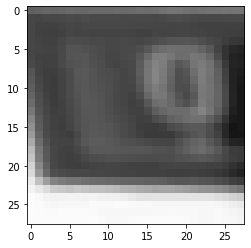

Resultado:  0  Esperado:  0
(28, 28)
(1, 28, 28, 1)
25
[[8.4173305e-05 9.9990511e-01 2.0001899e-14 2.9665673e-06 7.4474660e-06
  2.5473086e-09 1.4265564e-07 3.8782368e-09 2.4759346e-09 1.3040203e-07]]


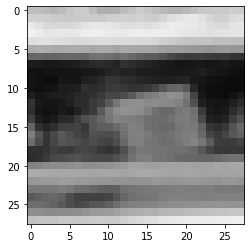

Resultado:  1  Esperado:  1
(28, 28)
(1, 28, 28, 1)
25
[[1.4348996e-07 2.0721109e-05 1.2021345e-05 9.9993062e-01 2.6710126e-05
  1.6252699e-06 2.0132077e-07 1.2774870e-08 6.3961097e-06 1.5852332e-06]]


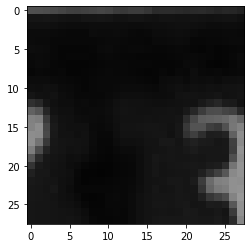

Resultado:  3  Esperado:  3
(28, 28)
(1, 28, 28, 1)
25
[[2.2646207e-10 1.2740378e-04 9.9417770e-01 1.0673823e-08 9.3742354e-05
  2.0513390e-07 1.9327421e-03 6.6725138e-06 7.3933660e-04 2.9222653e-03]]


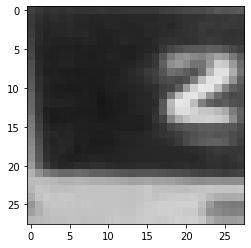

Resultado:  2  Esperado:  2
(28, 28)
(1, 28, 28, 1)
25
[[1.6650972e-07 1.4653885e-02 5.3981514e-11 9.8533648e-01 8.6655482e-06
  8.1227745e-07 8.2182351e-12 5.4875511e-16 3.7607299e-09 1.1422629e-11]]


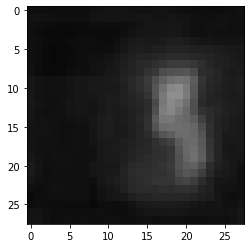

Resultado:  3  Esperado:  3
(28, 28)
(1, 28, 28, 1)
25
[[1.0000000e+00 1.9009527e-11 0.0000000e+00 4.4272666e-36 0.0000000e+00
  1.5952513e-34 3.0998296e-16 0.0000000e+00 2.6894028e-22 3.6743913e-23]]


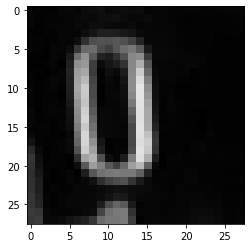

Resultado:  0  Esperado:  0


In [5]:
#Probar el codigo con imagenes de entrenamiento
import tensorflow as tf
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
# Test the model on random input data.
input_shape = input_details[0]['shape']

carpeta_salida_entrenar = "/content/drive/MyDrive/TFG/Fotos/Salida_para_entrenar"
all_images=os.listdir(carpeta_salida_entrenar)

for i in range(10):
    image_name = random.choice(all_images)
    input_data = cv.imread(os.path.join(carpeta_salida_entrenar,image_name),cv.IMREAD_GRAYSCALE)
    print(input_data.shape)
    #input_data = cv.equalizeHist(input_data)
    input_data = np.float32(input_data).reshape([1,28,28,1])
    print(input_data.shape)
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    print(output_details[0]['index'])
    output_data = interpreter.get_tensor(output_details[0]['index'])
    print(output_data)
    input_data =input_data.reshape([28,28])
    plt.imshow(input_data,cmap='gray', vmin=0, vmax=255)
    plt.show()
    print("Resultado: ",np.argmax(output_data)," Esperado: ",image_name.split("_")[0])
    #print(output_data.index(max(output_data)))

In [19]:
#Probar el codigo con todas imagenes de entrenamiento 
import tensorflow as tf
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']

carpeta_salida_entrenar = "/content/drive/MyDrive/TFG/Fotos/Salida_para_entrenar"
all_images=os.listdir(carpeta_salida_entrenar)
salida = []
labels = []
predictions = []
for i in range(len(all_images)):
    input_data = cv.imread(os.path.join(carpeta_salida_entrenar,all_images[i]),cv.IMREAD_GRAYSCALE)
    input_data = np.float32(input_data).reshape([1,28,28,1])
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    salida.append(str(np.argmax(output_data)) == all_images[i].split("_")[0])
    labels.append(int(all_images[i].split("_")[0]))
    predictions.append(np.argmax(output_data))

bien = salida.count(True)
mal = salida.count(False)
print("Acierta:",bien,"es un:",bien/len(all_images)*100)
print("Falla:",mal,"es un:",mal/len(all_images)*100)

#Matriz de comfusion

confusion = tf.math.confusion_matrix(labels=labels, predictions=predictions, num_classes=10)
print(confusion)

Acierta: 968 es un: 88.48263254113346
Falla: 126 es un: 11.517367458866545
tf.Tensor(
[[179   8   2   3   2   3   2   0   1   4]
 [  1 121   0   6   0   1   2   0   0   1]
 [  0   1 109   0   3   1   1   2   0   0]
 [  1   0   1  91   1   1   1   0   1   1]
 [  0   1   1   2  98   1   2   1   0   2]
 [  2   0   1   5   2  83   2   1   1   0]
 [  1   0   1   4   2   1  68   1   2   0]
 [  0   1   4   0   3   0   0  73   0   0]
 [  5   3   0   1   1   5   2   0  65   1]
 [  3   2   2   3   0   0   1   0   2  81]], shape=(10, 10), dtype=int32)


In [18]:
#Probar el codigo con todas imagenes de entrenamiento 
import tensorflow as tf
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']

carpeta_salida_entrenar = "/content/drive/MyDrive/TFG/Fotos/Salida_para_entrenar"
all_images=os.listdir(carpeta_salida_entrenar)
salida = []
labels = []
predictions = []
for i in range(len(x_train)):
    input_data = np.float32(x_train[i]).reshape([1,28,28,1])
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    salida.append(np.argmax(output_data) == y_train[i])
    labels.append(y_train[i])
    predictions.append(np.argmax(output_data))

bien = salida.count(True)
mal = salida.count(False)

print("Acierta:",bien,"es un:",bien/len(x_train)*100)
print("Falla:",mal,"es un:",mal/len(x_train)*100)

#Matriz de comfusion

confusion = tf.math.confusion_matrix(labels=labels, predictions=predictions, num_classes=10)
print(confusion)

{0.0: 96, 1.0: 107, 2.0: 91, 3.0: 77, 4.0: 90, 5.0: 80, 6.0: 73, 7.0: 66, 8.0: 66, 9.0: 70}
Acierta: 717 es un: 87.86764705882352
Falla: 99 es un: 12.132352941176471
tf.Tensor(
[[81  3  1  2  1  1  2  0  1  4]
 [ 1 97  0  6  0  1  1  0  0  1]
 [ 0  0 84  0  3  1  1  2  0  0]
 [ 1  0  1 70  1  1  1  0  1  1]
 [ 0  1  0  1 85  1  1  1  0  0]
 [ 2  0  1  4  2 67  2  1  1  0]
 [ 1  0  1  4  2  1 61  1  2  0]
 [ 0  1  4  0  2  0  0 59  0  0]
 [ 3  2  0  0  1  4  2  0 53  1]
 [ 2  2  2  2  0  0  0  0  2 60]], shape=(10, 10), dtype=int32)
